### Build a Basic Chatbot Using LangGraph (Graph API)

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)

In [3]:
graph_builder

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama-3.3-70b-versatile")

In [6]:
# Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [7]:
graph_builder=StateGraph(State)

# Adding node
graph_builder.add_node("llmchatbot",chatbot)
## Adding Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

# compile the graph
graph=graph_builder.compile()

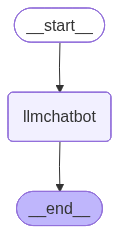

In [8]:
## Visualize the graph
## Visualize the graph
from IPython.display import Image, display

try:
    png_bytes = graph.get_graph().draw_mermaid_png(max_retries=5, retry_delay=2.0)
    display(Image(png_bytes))
except Exception as e:
    print("Failed to render graph:", e)

In [9]:
response=graph.invoke({"messages":"Hello"})

In [10]:
response["messages"][-1].content

'Hello. How can I assist you today?'

In [11]:
for event in graph.stream({"messages":"Hello How many million will make a billion?"}):
    for value in event.values():
        print(value["messages"][-1].content)


One billion is equal to 1,000 million. So, to make a billion, you would need 1,000 million.


**Tool Call**

In [12]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is node in langgraph?")

{'query': 'What is node in langgraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.youtube.com/watch?v=QbSPbILWIPw',
   'title': 'Nodes in LangGraph - YouTube',
   'content': 'Nodes in LangGraph\nA.I Engineering BootCamp\n2380 subscribers\n9 likes\n96 views\n13 Oct 2025\nJoin LangGraph classes at https://langcasts.com\n\nNodes are the "doers" of your LangGraph application—the functions that hold all the logic. But to build truly professional, production-ready agents, you need to know how these nodes access everything from the agent\'s memory to runtime configurations and tracing data.\nIn this essential tutorial, we dive deep into Nodes in LangGraph. We\'ll show you exactly what a node is, the critical arguments it can accept, and how to define a custom node function that leverages the agent\'s shared State, the execution Config, and the runtime Context. This is the key to decoupling your node logic from the rest of your graph, enabl

In [13]:
#Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [14]:
tools=[tool,multiply]
llm_with_tool=llm.bind_tools(tools)
llm_with_tool

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001438C3692B0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001438C369FD0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input

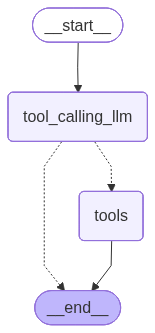

In [15]:
#Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph = builder.compile()

from IPython.display import Image, display
png_bytes = graph.get_graph().draw_mermaid_png(max_retries=5, retry_delay=2.0)
display(Image(png_bytes))

In [18]:
response=graph.invoke({"messages":"What is the recent ai news"})
response['messages'][-1].content

'{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://farmonaut.com/news/agriculture-technology-ai-news-october-2025-today", "title": "Agriculture Technology & AI News October 2025 Today - Farmonaut", "score": 0.6954834, "published_date": "Wed, 03 Dec 2025 06:37:39 GMT", "content": "# Agriculture Technology & AI News October 2025 Today: How AI Is Revolutionizing Farming and Food Security * Agriculture Technology News October 2025: AI, Precision Farming, and Smart Analytics Take Center Stage This comprehensive blog provides an in-depth journey through the **agriculture technology news October 2025**, spotlighting how AI-enabled systems are transforming farming from seed to supply chain. ## Agriculture Technology News October 2025: AI, Precision Farming, and Smart Analytics Take Center Stage These **advances** embody the **core of AI in agriculture news October 2025**: data-driven, precision, adaptive, and scalable—addressing

In [19]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (ymcp85zbt)
 Call ID: ymcp85zbt
  Args:
    query: recent ai news
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://farmonaut.com/news/agriculture-technology-ai-news-october-2025-today", "title": "Agriculture Technology & AI News October 2025 Today - Farmonaut", "score": 0.6954834, "published_date": "Wed, 03 Dec 2025 06:37:39 GMT", "content": "# Agriculture Technology & AI News October 2025 Today: How AI Is Revolutionizing Farming and Food Security * Agriculture Technology News October 2025: AI, Precision Farming, and Smart Analytics Take Center Stage This comprehensive b

In [20]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (mtx4c5z59)
 Call ID: mtx4c5z59
  Args:
    query: recent ai news
    topic: news
  multiply (b432r7p42)
 Call ID: b432r7p42
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.fool.com/investing/2025/11/27/10-ai-stocks-id-buy-right-now/", "title": "10 AI Stocks I'd Buy Right Now - The Motley Fool", "score": 0.7636429, "published_date": "Thu, 27 Nov 2025 14:00:00 GMT", "content": "* The recent artificial intelligence (AI) sell-off has created attractive entry points in names ranging from chipmakers to data center operators. Artificial intelligence (AI) 

**ReAct Agent**

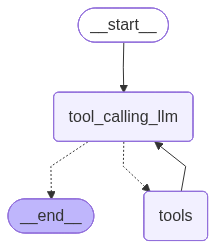

In [21]:
# Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
png_bytes = graph.get_graph().draw_mermaid_png(max_retries=5, retry_delay=2.0)
display(Image(png_bytes))

In [22]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (5jjn5gy05)
 Call ID: 5jjn5gy05
  Args:
    query: recent ai news
    topic: news
  multiply (1jc9dr4gx)
 Call ID: 1jc9dr4gx
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.fool.com/investing/2025/11/27/10-ai-stocks-id-buy-right-now/", "title": "10 AI Stocks I'd Buy Right Now - The Motley Fool", "score": 0.9871788, "published_date": "Thu, 27 Nov 2025 14:00:00 GMT", "content": "* The recent artificial intelligence (AI) sell-off has created attractive entry points in names ranging from chipmakers to data center operators. Artificial intelligence (AI) 

**Adding Memory in Agentic Graph**

In [23]:
response=graph.invoke({"messages":"Hello my name is Winnie"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is Winnie
================================== Ai Message ==================================

Hello Winnie, it's nice to meet you. Is there something I can help you with or would you like to chat?


In [24]:
response=graph.invoke({"messages":"What is my name"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is my name
================================== Ai Message ==================================

I don't have any information about your name. I'm a large language model, I don't have personal data about users, and our conversation just started. If you'd like to share your name, I'd be happy to chat with you!


In [29]:
# Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

In [30]:
config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"Hi my name is Winnie"},config=config)

response

{'messages': [HumanMessage(content='Hi my name is Winnie', additional_kwargs={}, response_metadata={}, id='3ffc211e-ab38-47de-b9ca-7f43cc1344c7'),
  AIMessage(content="Hello Winnie, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 1843, 'total_tokens': 1870, 'completion_time': 0.080797915, 'completion_tokens_details': None, 'prompt_time': 0.098010689, 'prompt_tokens_details': None, 'queue_time': 0.16146502, 'total_time': 0.178808604}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_43d97c5965', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--c6f0cd65-e3e2-4ced-bfb3-276c0a28f9cc-0', usage_metadata={'input_tokens': 1843, 'output_tokens': 27, 'total_tokens': 1870})]}

In [31]:
response['messages'][-1].content

"Hello Winnie, it's nice to meet you. Is there something I can help you with or would you like to chat?"

In [32]:
response=graph.invoke({"messages":"Hey what is my name"},config=config)

print(response['messages'][-1].content)

Your name is Winnie.


In [33]:
response=graph.invoke({"messages":"Hey do you remember mmy name"},config=config)

print(response['messages'][-1].content)

Yes, I remember your name is Winnie.


### Streaming

In [34]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [35]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

In [41]:
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


In [42]:
# Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi,My name is Winnie And I like Football"},config)

{'messages': [HumanMessage(content='Hi,My name is Winnie And I like Football', additional_kwargs={}, response_metadata={}, id='1a099d2d-10b1-4e2a-9190-ec4478f167c5'),
  AIMessage(content='Nice to meet you, Winnie. Football is an exciting sport. Are you a fan of a particular team or player? Do you have a favorite league, such as the English Premier League, La Liga, or the NFL?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 46, 'total_tokens': 93, 'completion_time': 0.118408284, 'completion_tokens_details': None, 'prompt_time': 0.004342791, 'prompt_tokens_details': None, 'queue_time': 0.144698207, 'total_time': 0.122751075}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_bebe2dd4fb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--f28fa960-e0e8-4373-a645-5608061c29e7-0', usage_metadata={'input_tokens': 46, 'output_tokens': 47, 'total_tokens': 93})]}

Methods: .stream() and astream()

These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

values : This streams the full state of the graph after each node is called.

updates : This streams updates to the state of the graph after each node is called.

In [43]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Winnie And I like Football"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Nice to meet you, Winnie. Football is an exciting sport, isn't it? Do you have a favorite team or player that you support?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 46, 'total_tokens': 77, 'completion_time': 0.067908763, 'completion_tokens_details': None, 'prompt_time': 0.004222944, 'prompt_tokens_details': None, 'queue_time': 0.049908085, 'total_time': 0.072131707}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_f8b414701e', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--6ae053da-836b-4eb2-aea1-080d39083ca0-0', usage_metadata={'input_tokens': 46, 'output_tokens': 31, 'total_tokens': 77})]}}


In [44]:
for chunk in graph_builder.stream({'messages':"Hi,My name is Winnie And I like Football"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Winnie And I like Football', additional_kwargs={}, response_metadata={}, id='8cde1fc8-8518-4e5c-9035-ab7ceea1b0e9'), AIMessage(content="Nice to meet you, Winnie. Football is an exciting sport, isn't it? Do you have a favorite team or player that you support?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 46, 'total_tokens': 77, 'completion_time': 0.067908763, 'completion_tokens_details': None, 'prompt_time': 0.004222944, 'prompt_tokens_details': None, 'queue_time': 0.049908085, 'total_time': 0.072131707}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_f8b414701e', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--6ae053da-836b-4eb2-aea1-080d39083ca0-0', usage_metadata={'input_tokens': 46, 'output_tokens': 31, 'total_tokens': 77}), HumanMessage(content='Hi,My name is Winnie And I like Football', additiona

In [45]:
# Create a thread
config = {"configurable": {"thread_id": "4"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Winnie And I like Football"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Hello Winnie, nice to meet you. Football is an exciting sport, is there a particular team or player you support?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 46, 'total_tokens': 72, 'completion_time': 0.104197189, 'completion_tokens_details': None, 'prompt_time': 0.002180497, 'prompt_tokens_details': None, 'queue_time': 0.049090482, 'total_time': 0.106377686}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_f8b414701e', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--d09e9995-95a0-4d30-b8df-2574d90d1b3e-0', usage_metadata={'input_tokens': 46, 'output_tokens': 26, 'total_tokens': 72})]}}


In [46]:
for chunk in graph_builder.stream({'messages':"I also like gaming"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Winnie And I like Football', additional_kwargs={}, response_metadata={}, id='50b88bcf-5200-475a-ae55-7922ddc0783e'), AIMessage(content='Hello Winnie, nice to meet you. Football is an exciting sport, is there a particular team or player you support?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 46, 'total_tokens': 72, 'completion_time': 0.104197189, 'completion_tokens_details': None, 'prompt_time': 0.002180497, 'prompt_tokens_details': None, 'queue_time': 0.049090482, 'total_time': 0.106377686}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_f8b414701e', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--d09e9995-95a0-4d30-b8df-2574d90d1b3e-0', usage_metadata={'input_tokens': 46, 'output_tokens': 26, 'total_tokens': 72}), HumanMessage(content='I also like gaming', additional_kwargs={}, response_metadata={

In [47]:
config = {"configurable": {"thread_id": "5"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is Winnie and I like to play games"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is Winnie and I like to play games']}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'a0bce7b8-9a1a-446d-8b62-3f491b9241a3', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is Winnie and I like to play games', additional_kwargs={}, response_metadata={}, id='ac642c5f-9017-49d3-970b-f6c2adfe90f8')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': '42d47721-2c96-4dea-9b31-75b3319fc60d', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:f059655e-1408-9242-5a66-b7ba2830797c'}, 'parent_ids': ['a0bce7b8-9a1a-446d-8b62-3f491b9241a3']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi My name is Winnie and I like to play